## Esquema del flujo de trabajo en el notebook

### 1. Procesamiento de datos

- **Importación de librerías**  
  Se cargan todas las librerías necesarias para análisis, visualización y modelado.

- **Carga y limpieza de datos de calidad**  
  - Importación de varias hojas del archivo Excel de calidad con `pd.read_excel()`.
  - Eliminación de columnas y filas irrelevantes (encabezados extra, pies de página).
  - Normalización de nombres de columnas y depuración de los DataFrames.

- **Unificación de datos de calidad**  
  - Concatenación de los DataFrames de las diferentes hojas en uno solo (`df_Calidad`).

- **Procesamiento de notas de catación**  
  - Limpieza y conversión de las notas en listas uniformes.
  - Aplicación de one-hot encoding para convertir cada nota en una variable binaria.

- **Carga y limpieza de datos de tostión**  
  - Importación de varias hojas del archivo Excel de tostión.
  - Eliminación de columnas y filas innecesarias.
  - Normalización de nombres de columnas y verificación de tipos de datos.

- **Unificación de datos de tostión**  
  - Concatenación de los DataFrames de tostión en uno solo (`df_Tostion`).

- **Fusión de datos de calidad y tostión**  
  - Unión de `df_Calidad` y `df_Tostion` usando la columna `LOTE` como clave para obtener un único DataFrame (`df_full`).

- **Transformación y corrección de variables**  
  - Conversión de columnas de tiempo y temperatura a formato numérico.
  - Unificación de valores categóricos inconsistentes (errores ortográficos, variantes).
  - Conversión de columnas numéricas al tipo adecuado.

---

### 2. Modelado y análisis

- **Selección de variables**  
  - Identificación de variables predictoras (X) y variable objetivo (Y).
  - Procesamiento de variables categóricas mediante pipelines y one-hot encoding.

- **Imputación de valores faltantes**  
  - Reemplazo de valores NaN en la variable objetivo.

- **División de los datos**  
  - Separación en conjuntos de entrenamiento y prueba con `train_test_split`.

- **Entrenamiento de modelos de regresión**  
  - Entrenamiento de modelos como RandomForestRegressor y XGBRegressor.

- **Evaluación de desempeño**  
  - Cálculo de métricas como MSE y R² en el conjunto de prueba.
  - Validación cruzada para evaluar la estabilidad y capacidad de generalización.

- **Interpretación y explicabilidad**  
  - Análisis de importancia de variables (feature importance).
  - Interpretación con SHAP para entender el impacto de cada variable.

- **Visualización y reporte de resultados**  
  - Gráficas de importancia de variables y comparación entre modelos.
  - Conclusiones sobre los factores que determinan

In [31]:
#Primero importamos todas las librerias que vamos a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Importamos las librerias de sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import shap



### 1. Procesamiento de datos

- **Carga de datos:**  
  Se importan varias hojas de archivos Excel de calidad y tostión usando `pd.read_excel()`, cada una como DataFrame independiente.

- **Limpieza:**  
  Se eliminan columnas y filas irrelevantes, se normalizan los nombres de columnas y se depuran los DataFrames para dejar solo la información útil.

- **Unificación:**  
  Se concatenan los DataFrames de calidad y de tostión por separado para obtener un solo DataFrame de cada tipo.

- **Procesamiento de notas de catación:**  
  Se transforman las notas sensoriales de texto a listas uniformes y luego se aplica one-hot encoding para convertir cada nota en una variable binaria.

- **Fusión de datos:**  
  Se realiza un merge entre los datos de calidad y tostión usando la columna `LOTE` como clave, generando un único DataFrame integrado.

- **Transformación de variables:**  
  Se convierten columnas de tiempo y temperatura a formato numérico y se corrigen inconsistencias en variables categóricas y numéricas para asegurar la calidad y compatibilidad de los datos para

In [32]:
#Primero Cargamos los datos almacenados en los archivos .xlsx
#Las primeras 5 filas de los archivos son encabezados, por lo cual las saltamos

dict_Calidad = pd.read_excel('CC_FT_17_Calidad.xlsx', 
                             sheet_name=['CONTROL CALIDAD CAFE TRILLADO J','Sheet2'],
                             skiprows=5)

#Accedemos a las hojas específicas del diccionario
#Quitamos las columnas que no son necesarias para el análisis, por ejemplo verificación física del café tostado tiene 
#Unicamente un valor y no aporta información relevante para el análisis

df_Calidad1 = dict_Calidad['CONTROL CALIDAD CAFE TRILLADO J']

#Las columnas sin nombre en este caso solo tienen un valor: 'C', por lo cual procedemos a eliminarlas.
df_Calidad1 = df_Calidad1.loc[:, ~df_Calidad1.columns.str.startswith('Unnamed')]

#quita espacios al principio y al final de cada nombre
df_Calidad1.columns = df_Calidad1.columns.str.strip()

df_Calidad1 = df_Calidad1.drop(columns=['FECHA','VERIFICACIÓN FISICA CAFÉ TOSTADO', 'LIBERACIÓN DE LOTE', 'RESPONSABLE'])

#Por ultimo eliminamos las filas 0 y 1 que no aportan información relevante y las ultimas filas.

df_Calidad1 = df_Calidad1.drop(index=[0,1])
df_Calidad1 = df_Calidad1.iloc[:-17]


# Realizamos una visualización rápida de los datos en cada hoja

display(df_Calidad1.head())
display(df_Calidad1.tail())


,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,NOTAS DE CATACIÓN,PUNTAJE
2,01-190722,Madre Laura,765.00,10.9,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
3,09-190722,Tabi Natural,204.00,10.2,14,"Frutas maduras, nibs de cacao, acidez brillant...",85
4,10-190722,Don Mario,165.00,10.7,14,"Panela, durazno, miel, acidez brillante citric...",84.5
5,07-19-07-22,Don Felix,0.45,10.5,14,"Moras maduras, chocolate negro, acidez media c...",84.5
6,01-291022,Madre Laura,105.00,10.7,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84


,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,NOTAS DE CATACIÓN,PUNTAJE
73,22-170624,El Ocaso - Caturron,48.0,10.3,15,"Chocolate dulce, nuez moscada, acidez jugosa, ...",87
74,01-030724,Madre Laura,250.0,10.4,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
75,23-150724,Esteban Robledo,60.0,10.6,14,"Panela, almendras, acidez citrica jugosa como ...",85
76,02-150724,Madre Laura Natural,175.0,10.8,14,"Cacao, frutos rojos, cuerpo cremoso, acidez br...",85
77,17-270724,Familia Bedoya Castaño,35.0,10.8,14,"Melao de panela, arandanos, cuerpo cremoso, ac...",87


In [33]:
#Ahora hacemos un tratamiento similar con la segunda hoja del archivo Excel
df_Calidad2 = dict_Calidad['Sheet2']

df_Calidad2 = df_Calidad2.loc[:, ~df_Calidad2.columns.str.startswith('Unnamed')]
df_Calidad2.columns = df_Calidad2.columns.str.strip()
df_Calidad2 = df_Calidad2.drop(columns=['FECHA','VERIFICACIÓN FISICA CAFÉ TOSTADO', 'LIBERACIÓN DE LOTE', 'RESPONSABLE'])
df_Calidad2 = df_Calidad2.drop(index=[0,1])
df_Calidad2 = df_Calidad2.iloc[:-12]

display(df_Calidad2.head())
display(df_Calidad2.tail())

,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,NOTAS DE CATACIÓN,PUNTAJE
2,01-300822,Madre Laura,32.0,"10,5",14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
3,01-131022,Madre Laura,79.8,10.4,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
4,01-181022,Madre Laura,38.0,10.5,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
5,05-181022,Doña Dolly,43.0,10,14,"Chocolate dulce,fresas,miel,cuerpo cremoso,aci...",85
6,01-291022,Madre Laura,272.0,10.5,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84


,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,NOTAS DE CATACIÓN,PUNTAJE
29,01-271023,Madre Laura,20.0,10.5,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
30,01-100124,Madre Laura,20.0,10.4,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
31,01-020424,Madre Laura,20.0,10.5,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
32,01-200624,Madre Laura,14.0,10.8,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
33,01-180724,Madre Laura,20.0,10.2,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84


In [34]:
#Ahora unimos los dos dataframes en uno solo por filas

df_Calidad = pd.concat([df_Calidad1, df_Calidad2], axis=0, ignore_index=True)

display(df_Calidad.head())
display(df_Calidad.tail())

,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,NOTAS DE CATACIÓN,PUNTAJE
0,01-190722,Madre Laura,765.00,10.9,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
1,09-190722,Tabi Natural,204.00,10.2,14,"Frutas maduras, nibs de cacao, acidez brillant...",85
2,10-190722,Don Mario,165.00,10.7,14,"Panela, durazno, miel, acidez brillante citric...",84.5
3,07-19-07-22,Don Felix,0.45,10.5,14,"Moras maduras, chocolate negro, acidez media c...",84.5
4,01-291022,Madre Laura,105.00,10.7,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84


,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,NOTAS DE CATACIÓN,PUNTAJE
103,01-271023,Madre Laura,20.0,10.5,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
104,01-100124,Madre Laura,20.0,10.4,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
105,01-020424,Madre Laura,20.0,10.5,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
106,01-200624,Madre Laura,14.0,10.8,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84
107,01-180724,Madre Laura,20.0,10.2,14,"Chocolate negro, toque frutal, cuerpo medio, a...",84


Las notas de cata del café constituyen variables categóricas muy relevantes para el modelo. Para incorporarlas sin introducir un orden arbitrario, aplicamos one-hot encoding: creamos una columna por cada nota de cata (por ejemplo, “Sabor afrutado”, “Cuerpo ligero”, “Aroma floral”, etc.) y asignamos un 1 si el café presenta dicha nota, o un 0 en caso contrario.

Este enfoque:

- Mantiene intacta la información cualitativa de cada nota sin reducirla a un único valor numérico.
- Facilita que los algoritmos de regresión interpreten correctamente la presencia o ausencia de cada característica sensorial.
- Permite evaluar la importancia individual de cada nota mediante técnicas de explicabilidad (Feature Importance, SHAP, LIME).

De este modo, garantizamos que el modelo reciba entradas limpias y libres de sesgos de orden, y podamos extraer conclusiones precisas sobre qué atributos de cata influyen más en la calidad final del café.


#### Nota importante:
Las notas de catación suelen estar separadas por comas (',') en la mayoría de los casos, pero la última nota a menudo se encuentra separada por la conjunción 'y'. Por ejemplo: "Aromático, Dulce y Floral".  
Para asegurar una correcta separación de todas las notas, el preprocesamiento reemplaza cualquier ' y ' por una coma antes de dividir el texto en una lista de notas. Así, todas las notas quedan correctamente identificadas y listas para el análisis.

In [35]:
#Primero modificamos los datos de la columna 'NOTAS DE CATACIÓN' para convertirlos en una lista de notas
# El proceso a continuacion nos garantiza la uniformidad de los datos, pues garantiza que cada nota este en un formato uniforme.
# Limpia espacios redundantes y divide en lista
df_Calidad['NOTAS DE CATACIÓN'] = (
    df_Calidad['NOTAS DE CATACIÓN']
      .fillna('')  # en caso de NaN
      .str.replace(r'\s+y\s+', ',', regex=True)  # reemplaza ' y ' por ','
      .str.replace(r'\s*,\s*', ',', regex=True)  # limpia espacios alrededor de comas
      .str.split(',')  # ahora cada fila es lista de notas
      .apply(lambda notas: [n.strip().rstrip('.') for n in notas if n])  # quita puntos finales y espacios
)

display(df_Calidad.head(10))

,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,NOTAS DE CATACIÓN,PUNTAJE
0,01-190722,Madre Laura,765.00,10.9,14,"[Chocolate negro, toque frutal, cuerpo medio, ...",84
1,09-190722,Tabi Natural,204.00,10.2,14,"[Frutas maduras, nibs de cacao, acidez brillan...",85
2,10-190722,Don Mario,165.00,10.7,14,"[Panela, durazno, miel, acidez brillante citri...",84.5
3,07-19-07-22,Don Felix,0.45,10.5,14,"[Moras maduras, chocolate negro, acidez media ...",84.5
4,01-291022,Madre Laura,105.00,10.7,14,"[Chocolate negro, toque frutal, cuerpo medio, ...",84
5,01-291022,Madre Laura,105.00,10.7,14,"[Chocolate negro, toque frutal, cuerpo medio, ...",84
6,01-101122,Madre Laura,210.00,10.7,14,"[Chocolate negro, toque frutal, cuerpo medio, ...",84
7,08-241122,Gesha Villabernarda,12.00,10.3,14,"[Jazmin, mandarina, acidez jugosa, cuerpo sedo...",86
8,02-241122,Madre Laura Natural,19.40,10.5,14,"[Cacao, frutos rojos, cuerpo cremoso, acidez b...",85
9,05-241122,Doña Dolly,35.00,10.8,14,"[Panela, fresa, acidez brillante, cuerpo cremo...",85


### ¿Qué hace `str.get_dummies(sep=',')` en el código a continuación?

1. **Lectura de cada celda como texto**  
   Extrae el contenido de la celda donde las notas están separadas por comas.

2. **Separación por comas**  
   Divide esa cadena en fragmentos individuales usando la coma como separador.

3. **Creación de columnas únicas**  
   Por cada fragmento distinto detectado en todo el DataFrame, genera una nueva columna.

4. **Asignación de valores binarios (0/1)**  
   Asigna un `1` en cada fila si el fragmento aparece en la celda original, o un `0` si no.

In [36]:
# Primero vuelve a la versión “unida en un string” para facilitar la creación de dummies:
df_Calidad['_tmp'] = df_Calidad['NOTAS DE CATACIÓN'].apply(lambda lst: ','.join(lst) if isinstance(lst, list) else '')

# Luego crea dummies (cada nota = columna 0/1)
dummies = df_Calidad['_tmp'].str.get_dummies(sep=',')
dummies.columns = [col.strip() for col in dummies.columns] 
display(dummies.head(10))


,Arandanos,Azucar morena,Cacao,Caña de azucar,Cereza,Chocolate dulce,Chocolate negro,Frambuesa,Fresa,Frutas amarillas,...,nibs de cacao,nueces,nuez moscada,panela,prolongado,residual a cascara de mandarina,residual frutal a naranja,te de cedron,toque frutal,vainilla
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Junta al df original lo producido anteriormente
# Esto elimina la columna temporal y la original de notas de cata, dejando solo las dummies
# Esto nos permite tener un dataframe con las notas de cata como columnas, donde cada columna 
# representa una nota y su valor es 0 o 1 dependiendo de si la nota esta presente o no en la fila.
df_Calidad = pd.concat([df_Calidad.drop(columns=['_tmp','NOTAS DE CATACIÓN']), dummies], axis=1)
df_Calidad.head(10)

,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,PUNTAJE,Arandanos,Azucar morena,Cacao,Caña de azucar,...,nibs de cacao,nueces,nuez moscada,panela,prolongado,residual a cascara de mandarina,residual frutal a naranja,te de cedron,toque frutal,vainilla
0,01-190722,Madre Laura,765.00,10.9,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,09-190722,Tabi Natural,204.00,10.2,14,85,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,10-190722,Don Mario,165.00,10.7,14,84.5,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,07-19-07-22,Don Felix,0.45,10.5,14,84.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01-291022,Madre Laura,105.00,10.7,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,01-291022,Madre Laura,105.00,10.7,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,01-101122,Madre Laura,210.00,10.7,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,08-241122,Gesha Villabernarda,12.00,10.3,14,86,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,02-241122,Madre Laura Natural,19.40,10.5,14,85,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,05-241122,Doña Dolly,35.00,10.8,14,85,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Cambiamos el nombre de la columna 'DENOMINACIÓN/ MARCA'

df_Calidad.rename(columns={'DENOMINACIÓN/     MARCA': 'MARCA'}, inplace=True)
df_Calidad.head(10)

,LOTE,MARCA,CANTIDAD,%H,MALLAS,PUNTAJE,Arandanos,Azucar morena,Cacao,Caña de azucar,...,nibs de cacao,nueces,nuez moscada,panela,prolongado,residual a cascara de mandarina,residual frutal a naranja,te de cedron,toque frutal,vainilla
0,01-190722,Madre Laura,765.00,10.9,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,09-190722,Tabi Natural,204.00,10.2,14,85,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,10-190722,Don Mario,165.00,10.7,14,84.5,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,07-19-07-22,Don Felix,0.45,10.5,14,84.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01-291022,Madre Laura,105.00,10.7,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,01-291022,Madre Laura,105.00,10.7,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,01-101122,Madre Laura,210.00,10.7,14,84,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,08-241122,Gesha Villabernarda,12.00,10.3,14,86,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,02-241122,Madre Laura Natural,19.40,10.5,14,85,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,05-241122,Doña Dolly,35.00,10.8,14,85,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Procesamiento de datos de tostión y fusión de tablas

A continuación incorporamos la información de la etapa de tostión:

1. **Carga y preprocesamiento de la hoja de tostión**  
   - Leemos el archivo `CC_FT_18_Tostion.xlsx` con `pd.read_excel`, apuntando a la hoja correspondiente.  
   - Aplicamos limpieza y transformación de columnas:  
     - Eliminación de filas de encabezado o pie de página innecesarios.  
     - Conversión de tipos de dato (fechas, numéricos).  
     - Normalización de nombres de columnas (quita espacios, tildes uniformes).

2. **Unión con el DataFrame de calidad**  
   - Realizamos un _merge_ entre `df_Calidad` y el nuevo DataFrame `df_Tostion` usando la columna común `LOTE`, que identifica de forma única cada lote de café.  
   - Empleamos por ejemplo:  
     ```python
     df_full = pd.merge(
         df_Calidad,
         df_Tostion,
         on='LOTE',
         how='inner'   # conserva solo los lotes presentes en ambas tablas
     )
     ```  
   - Con esta fusión obtenemos un único DataFrame enriquecido, que combina las variables sensoriales de calidad con los parámetros de tostión, listo para el análisis y el entrenamiento de nuestros modelos de regresión.


In [39]:
# Cargamos el archivo de datos de tostion del café
dict_Tostion = pd.read_excel('CC_FT_18_Tostion.xlsx', 
                           sheet_name=['TOSTIÓN JERICÓ L', 'TOSTIÓN JERICÓ'],
                           skiprows=5)

# Accedemos a las hojas específicas del diccionario
df_Tostion1 = dict_Tostion['TOSTIÓN JERICÓ L']
df_Tostion2 = dict_Tostion['TOSTIÓN JERICÓ']

# Visualizamos los datos de tostion
display(df_Tostion1.head())
display(df_Tostion1.tail())


,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste,Observaciones,Tostador
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,08:01:00,NaN,LFQ
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,175°/195°,08:42:00,NaN,LFQ
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,07:58:00,NaN,LFQ
3,28-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,08:02:00,NaN,LFQ
4,28-07-22,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,150°/186°,08:10:00,NaN,LFQ


,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste,Observaciones,Tostador
494,13-8-24,01-120424,Jerico,Dos mil,Tradicional,Lavado,54.0,16.666667,45.0,Filtrados,180°/193°,08:58:00,NaN,LFQ
495,13-8-24,08-140524,Jerico,Gesha,Honey,Honey,3.0,16.666667,2.5,Filtrados,175°/191°,08:10:00,NaN,LFQ
496,13-8-24,22-170624,Salento,Caturron,Natural,Natural,3.0,16.666667,2.5,Filtrados,175°/189°,08:01:00,NaN,LFQ
497,13-8-24,21-130224,Planadas,Red Bourbon,Honey,Honey,3.0,16.666667,2.5,Filtrados,170°/190°,08:09:00,NaN,LFQ
498,13-8-24,23-150724,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.5,Filtrados,175°/191°,08:21:00,NaN,LFQ


In [40]:
display(df_Tostion2.head())
display(df_Tostion2.tail())

,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste,Observaciones,Tostador
0,2022-10-08 00:00:00,1-190722,Jerico,Colombia,Tradicional,Lavado,3.0,15.000000,2.55,Filtrado,180°-190°,9:58,NaN,AC
1,2022-10-08 00:00:00,1-190722,Jerico,Colombia,Tradicional,Lavado,3.0,15.000000,2.55,Filtrado,180°-181°,8:32,NaN,AC
2,20-09-2022,01-300822,Jerico,Colombia,Tradicional,Lavado,3.0,15.000000,2.55,Filtrado,180°-190°,9:58,NaN,AC
3,13-10-2022,01-131022,Jerico,Colombia,Tradicional,Lavado,93.0,16.666667,77.50,Espresso,180°-195°,11:40,Epoca,AC
4,18-10-2022,01-181022,Jerico,Colombia,Tradicional,Lavado,42.0,14.285714,36.00,Filtrado,180°-192°,10.15,NaN,LFQ


,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste,Observaciones,Tostador
25,27-10-2023,01-271023,Jerico,Colombia,Tradicional,Lavado,15.60,15.705128,13.15,Filtrado,180°-190°,9.36,Jericó,AC
26,2024-01-10 00:00:00,01-100124,Jerico,Colombia,Tradicional,Lavado,15.00,13.333333,13.00,Filtrado,180°-190°,9.32,Jericó,AC
27,2024-04-02 00:00:00,01-020424,Jerico,Colombia,Tradicional,Lavado,14.50,16.551724,12.10,Filtrado,180°-190°,9.36,Jericó,AC
28,2024-06-20 00:00:00,01-200624,Jerico,Colombia,Tradicional,lavado,10.70,13.551402,9.25,Filtrado,180°-190°,9.28,Jericó,AC
29,2024-07-18 00:00:00,01-180724,Jerico,Colombia,Tradicional,lavado,15.65,15.654952,13.20,Filtrado,180°-190°,9.30,Jericó,AC


In [41]:
# Unimos los dos dataframes de tostion en uno solo por filas
df_Tostion = pd.concat([df_Tostion1, df_Tostion2], axis=0, ignore_index=True)
display(df_Tostion.head())
display(df_Tostion.tail())

,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste,Observaciones,Tostador
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,08:01:00,NaN,LFQ
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,175°/195°,08:42:00,NaN,LFQ
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,07:58:00,NaN,LFQ
3,28-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,08:02:00,NaN,LFQ
4,28-07-22,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,150°/186°,08:10:00,NaN,LFQ


,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste,Observaciones,Tostador
524,27-10-2023,01-271023,Jerico,Colombia,Tradicional,Lavado,15.60,15.705128,13.15,Filtrado,180°-190°,9.36,Jericó,AC
525,2024-01-10 00:00:00,01-100124,Jerico,Colombia,Tradicional,Lavado,15.00,13.333333,13.00,Filtrado,180°-190°,9.32,Jericó,AC
526,2024-04-02 00:00:00,01-020424,Jerico,Colombia,Tradicional,Lavado,14.50,16.551724,12.10,Filtrado,180°-190°,9.36,Jericó,AC
527,2024-06-20 00:00:00,01-200624,Jerico,Colombia,Tradicional,lavado,10.70,13.551402,9.25,Filtrado,180°-190°,9.28,Jericó,AC
528,2024-07-18 00:00:00,01-180724,Jerico,Colombia,Tradicional,lavado,15.65,15.654952,13.20,Filtrado,180°-190°,9.30,Jericó,AC


In [42]:
# Procedemos a asegurar que los datos de tostion son consistentes, en especial el nombre de las columnas

df_Tostion.columns = df_Tostion.columns.str.strip()  # Quita espacios al principio y al final de cada nombre

In [43]:
# Ahora se procesan los datos de tostion:
# Quitamos las columnas que no son necesarias para el análisis, por ejemplo la columna de fecha y observaciones
# que no aportan información relevante para el análisis

df_Tostion = df_Tostion.drop(columns=['Fecha', 'Observaciones','Tostador'])
# Visualizamos los datos de tostion después de la limpieza
display(df_Tostion.head())

#adicionalmente, examinamos los tipos de datos de las columnas para asegurarnos de que son correctos
print(df_Tostion.dtypes)

,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste
0,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,08:01:00
1,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,175°/195°,08:42:00
2,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,07:58:00
3,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,08:02:00
4,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,150°/186°,08:10:00


Lote                        object
Origen                      object
Variedad                    object
Proceso                     object
Beneficio                   object
Peso en Verde              float64
Merma                      float64
Peso en Tostado            float64
Perfil                      object
Temp. De inicio y final     object
Tiempo de tueste            object
dtype: object


### Unión de los datos

Una vez que los datos de calidad y de tostión han sido limpiados y procesados por separado, procedemos a integrarlos en un solo DataFrame para el análisis final y el modelado.

- **Clave de unión:**  
  Utilizamos la columna `LOTE` como identificador único, ya que está presente en ambos conjuntos de datos y permite relacionar correctamente la información sensorial (calidad) con los parámetros de tostión para cada muestra de café.

- **Método de unión:**  
  Empleamos la función `pd.merge()` de pandas para realizar la fusión de los DataFrames:
  - Usamos el parámetro `on='LOTE'` para indicar la columna clave.
  - El parámetro `how='inner'` asegura que solo se conserven los lotes que están presentes en ambos conjuntos de datos, garantizando la consistencia de la información.

- **Resultado:**  
  El DataFrame resultante contiene, para cada lote, tanto las variables sensoriales y categóricas de calidad como los datos técnicos de tostión. Esto permite realizar análisis integrales y entrenar modelos de regresión que consideren todas las variables relevantes.

**Ejemplo de código para la unión:**
```python
df_full = pd.merge(
    df_Calidad,
    df_Tostion,
    on='Lote',
    how='inner'  # Solo lotes presentes en ambos DataFrames
)
display(df_full.head())
```
De este modo, obtenemos un único DataFrame listo para el análisis exploratorio, la selección de variables y el entrenamiento

In [44]:
# Ahora que tenemos los datos de calidad y tostion, podemos proceder a unirlos
# Primero aseguramos que las columnas de unión son las mismas en ambos dataframes

df_full = pd.merge(df_Calidad, df_Tostion, left_on='LOTE', right_on='Lote', how='inner')

display(df_full.head())
df_full.info()

,LOTE,MARCA,CANTIDAD,%H,MALLAS,PUNTAJE,Arandanos,Azucar morena,Cacao,Caña de azucar,...,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste
0,01-190722,Madre Laura,765.0,10.9,14,84,0,0,0,0,...,Jerico,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,175°/191°,08:01:00
1,01-190722,Madre Laura,765.0,10.9,14,84,0,0,0,0,...,Jerico,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espressso,175°/195°,08:42:00
2,01-190722,Madre Laura,765.0,10.9,14,84,0,0,0,0,...,Jerico,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,175°/190°,07:58:00
3,01-190722,Madre Laura,765.0,10.9,14,84,0,0,0,0,...,Jerico,Dos mil,Tradicional,Lavado,11.7,16.324786,9.79,Filtrado,175°/191°,08:02:00
4,01-190722,Madre Laura,765.0,10.9,14,84,0,0,0,0,...,Jerico,Dos mil,Tradicional,Lavado,29.0,15.344828,24.55,Filtrado,175°/192°,08:02:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Columns: 106 entries, LOTE to Tiempo de tueste
dtypes: float64(4), int64(89), object(13)
memory usage: 388.5+ KB


Por último, es necesario transformar las columnas 'Temp. De inicio y final' y 'Tiempo de tueste' a un formato numérico para que puedan ser utilizadas correctamente en el análisis y modelado.  
- En la columna 'Temp. De inicio y final', se extraen las temperaturas de inicio y final como valores numéricos separados, creando dos nuevas columnas: 'Temp_inicio' y 'Temp_final'.  
- En la columna 'Tiempo de tueste', se convierte el tiempo registrado en formato de texto (por ejemplo, '08:01:00') a minutos o segundos, generando una nueva columna numérica que representa la duración total del tueste.  
De esta manera, ambas variables quedan listas para ser utilizadas por los modelos de machine learning.

In [45]:
# Procesar columna 'Temp. De inicio y final'
df_full[['Temp_inicio', 'Temp_final']] = df_full['Temp. De inicio y final'].str.extract(r'(\d+)[°º]*/(\d+)[°º]*').astype(float)
# Procesar columna 'Tiempo de tueste' a minutos
# Primero convertimos la columna 'Tiempo de tueste' a un formato de tiempo adecuado
df_full['Tiempo de tueste'] = pd.to_datetime(
    df_full['Tiempo de tueste'],
    format='%H:%M:%S',    # ajusta si tu formato es distinto
    errors='coerce'       # convierte a NaT las cadenas mal formateadas
)

# Extraemos las horas, minutos y segundos
df_full['Tiempo de tueste'] = (
    df_full['Tiempo de tueste'].dt.hour * 60 +
    df_full['Tiempo de tueste'].dt.minute +
    df_full['Tiempo de tueste'].dt.second / 60
)

En las columnas 'Origen', 'Beneficio', 'Perfil' y 'Proceso' existen inconsistencias en los formatos de los valores, como por ejemplo la presencia de variantes ortográficas ('expressso' y 'expresso') para referirse al mismo perfil de café. Estas diferencias pueden afectar el análisis y el modelado, ya que los algoritmos tratarán cada variante como una categoría distinta. Por ello, es importante unificar y corregir estos valores antes de aplicar técnicas de codificación o análisis, asegurando así la coherencia y calidad

In [46]:
#unificamos los errores en la columna 'Origen'

correcciones_Origen = {
    'Herrra ': 'Herrera',
    'Herrerra': 'Herrera',
    'Herrera ': 'Herrera',
    'Jerico ': 'Jerico',
    'Jericó ': 'Jerico'
}

df_full['Origen'] = df_full['Origen'].replace(correcciones_Origen)

# Unificamos los errores en la columna 'Variedad'

correcciones_variedad = {
    'Caturra ': 'Caturra'
}

df_full['Variedad'] = df_full['Variedad'].replace(correcciones_variedad)

# Unificamos los errores en la columna 'Perfil'

correcciones_perfil = {
    'Expressso': 'Espresso',
    'Expresso': 'Espresso',
    'Espresso': 'Espresso',
    'Espressso' : 'Espresso',
    'Espresso ': 'Espresso',
    'Filtrados': 'Filtrado',
    'Filtrado ': 'Filtrado',
    'Filtrados ' : 'Filtrado',
}

df_full['Perfil'] = df_full['Perfil'].replace(correcciones_perfil)

# Ahora unificamos los errores en la columna 'Beneficio'

correcciones_beneficio = {
    'lavado': 'Lavado',
    'Lavado ': 'Lavado',
    'lavado ': 'Lavado',
}

df_full['Beneficio'] = df_full['Beneficio'].replace(correcciones_beneficio)

# Unificamos los errores en la columna 'Proceso'

correcciones_proceso = {
    'Tradicional': 'Tradicional',
    'Tradicional ': 'Tradicional',
    'tradicional ' : 'Tradicional'
}

df_full['Proceso'] = df_full['Proceso'].replace(correcciones_proceso)




In [47]:
# Desplegamos la información del dataframe completo para verificar que la unión se realizó correctamente
df_full.info()
df_full.shape
df_full.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Columns: 108 entries, LOTE to Temp_final
dtypes: float64(7), int64(89), object(12)
memory usage: 395.8+ KB


['LOTE',
 'MARCA',
 'CANTIDAD',
 '%H',
 'MALLAS',
 'PUNTAJE',
 'Arandanos',
 'Azucar morena',
 'Cacao',
 'Caña de azucar',
 'Cereza',
 'Chocolate dulce',
 'Chocolate negro',
 'Frambuesa',
 'Fresa',
 'Frutas amarillas',
 'Frutas maduras',
 'Jalea',
 'Jazmin',
 'Lavanda',
 'Limonaria',
 'Manzana roja',
 'Maracuya',
 'Melao de panela',
 'Moras maduras',
 'Panela',
 'Rosas',
 'Sandia',
 'Uva',
 'acidez brillante',
 'acidez brillante citrica',
 'acidez brillante citrica como mandarina',
 'acidez citrica como la naranja',
 'acidez citrica jugosa como la mandrina',
 'acidez jugosa',
 'acidez jugosa citrica',
 'acidez jugosa como tamarindo',
 'acidez malica',
 'acidez malica brillante',
 'acidez media citrica como naranja',
 'almendras',
 'arandanos',
 'balanaceado',
 'caramelo',
 'caramleo',
 'cedro',
 'chocolate al 70%',
 'chocolate negro',
 'ciruela madura',
 'clavos de olor',
 'cuepo cremoso',
 'cuerpo aterciopelado',
 'cuerpo cremoso',
 'cuerpo cremoso medio',
 'cuerpo medio',
 'cuerpo se

### 2. Modelo y análisis

En esta sección se abordará el modelado predictivo de la calidad del café utilizando los datos previamente procesados y fusionados. El objetivo es predecir la variable de calidad (score) a partir de las características sensoriales y técnicas de cada lote.

El procedimiento será el siguiente:

1. **Selección de variables**
   - Se identifican las variables predictoras (X) y la variable objetivo (Y) a partir del DataFrame `df_full`.
   - Antes del modelado, se realizará un procedimiento adicional para el procesamiento de los datos cualitativos (categóricos). Se utilizará un **pipeline** de scikit-learn junto con **OneHotEncoder** para transformar automáticamente las variables categóricas en variables numéricas (dummies) dentro del flujo de entrenamiento y validación de los modelos.  
Esto asegura que cualquier columna categórica sea correctamente codificada y que el preprocesamiento sea reproducible y consistente durante todo el proceso de

2. **División de los datos**
   - Se separan los datos en tres conjuntos: entrenamiento y prueba, utilizando `train_test_split`. Esto permite entrenar los modelos, ajustar hiperparámetros y evaluar el desempeño de manera objetiva

3. **Entrenamiento de modelos de regresión**
   - Se entrenarán dos modelos de regresión:
     - **RandomForestRegressor:** Modelo de ensamble basado en árboles de decisión, robusto ante variables categóricas y capaz de capturar relaciones no lineales.
     - **XGBRegressor:** Modelo de boosting basado en árboles, eficiente y con gran capacidad de predicción en datos tabulares.

4. **Evaluación de desempeño**
   - Se evaluarán ambos modelos utilizando métricas como RMSE (Root Mean Squared Error), MAE (Mean Absolute Error) y R² (coeficiente de determinación).
   - Se compararán los resultados para seleccionar el modelo más adecuado.

5. **Interpretación y explicabilidad**
   - Se analizará la importancia de las variables en cada modelo para identificar qué características influyen más en la calidad del café.
   - Se utilizarán dos enfoques principales:
     - **Feature Importance:** Permite visualizar y cuantificar la contribución de cada variable al modelo, especialmente útil en RandomForestRegressor y XGBRegressor.
     - **SHAP (SHapley Additive exPlanations):** Proporciona una explicación más detallada y local/global sobre cómo cada variable afecta las predicciones del modelo, ayudando a interpretar el impacto individual de cada característica en la predicción de la calidad del café.

6. **Visualización de resultados**
   - Se presentarán gráficas comparando las predicciones de los modelos con los valores reales y se mostrarán los principales hallazgos.

Este enfoque permite comparar dos de los modelos más potentes para regresión en datos tabulares y obtener conclusiones sólidas sobre los factores que determinan la calidad del café.

En los datos algunas variables que deberían ser numéricas (por ejemplo: %H o PUNTAJE) están siendo interpretadas como categóricas (tipo 'object'). Por ello, es necesario convertir estas columnas al tipo numérico adecuado antes de continuar con el preprocesamiento y modelado, para asegurar que los algoritmos las traten correctamente y evitar errores

In [48]:
# Cambiamos los tipos de datos de las columnas que deberían ser numéricas
df_full['%H'] = pd.to_numeric(df_full['%H'], errors='coerce')
df_full['PUNTAJE'] = pd.to_numeric(df_full['PUNTAJE'], errors='coerce')
df_full['MALLAS'] = pd.to_numeric(df_full['MALLAS'], errors='coerce')



In [49]:
# Para nuestra variable objetivo, utilizaremos la columna 'PUNTAJE' que es la que representa la calidad del café.
# Esta columna contiene los puntajes de calidad asignados a cada lote de café

Y = df_full['PUNTAJE']
X = df_full.drop(columns=['LOTE', 'PUNTAJE', 'Lote', 'Temp. De inicio y final'])

display(X.head())

print(X.dtypes)

,MARCA,CANTIDAD,%H,MALLAS,Arandanos,Azucar morena,Cacao,Caña de azucar,Cereza,Chocolate dulce,...,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Tiempo de tueste,Temp_inicio,Temp_final
0,Madre Laura,765.0,10.9,14,0,0,0,0,0,0,...,Dos mil,Tradicional,Lavado,9.0,15.000000,7.65,Filtrado,481.0,175.0,191.0
1,Madre Laura,765.0,10.9,14,0,0,0,0,0,0,...,Dos mil,Tradicional,Lavado,3.0,16.666667,2.50,Espresso,522.0,175.0,195.0
2,Madre Laura,765.0,10.9,14,0,0,0,0,0,0,...,Dos mil,Tradicional,Lavado,9.0,16.444444,7.52,Filtrado,478.0,175.0,190.0
3,Madre Laura,765.0,10.9,14,0,0,0,0,0,0,...,Dos mil,Tradicional,Lavado,11.7,16.324786,9.79,Filtrado,482.0,175.0,191.0
4,Madre Laura,765.0,10.9,14,0,0,0,0,0,0,...,Dos mil,Tradicional,Lavado,29.0,15.344828,24.55,Filtrado,482.0,175.0,192.0


MARCA                object
CANTIDAD            float64
%H                  float64
MALLAS                int64
Arandanos             int64
                     ...   
Peso en Tostado     float64
Perfil               object
Tiempo de tueste    float64
Temp_inicio         float64
Temp_final          float64
Length: 104, dtype: object


In [50]:
# Ahora que separamos las variables independientes (X) de la dependiente (Y),
# procedemos a realizar el pipeline para procesar los datos cualitativos (categóricos).

Pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

X_categorical = X.select_dtypes(include=['object'])

display(X_categorical.head())

# Procedemos a transformar las variables categóricas en variables numéricas (dummies) dentro del flujo de entrenamiento y validación de los modelos.
X_transformed = Pipe.fit_transform(X_categorical)

# Ahora unimos las variables transformadas con las variables numéricas
X_numerical = X.select_dtypes(exclude=['object'])
X_full = pd.concat([X_numerical, pd.DataFrame(X_transformed, columns=Pipe.get_feature_names_out())], axis=1)

# visualizamos las primeras filas del dataframe completo
X_full.head(10)


,MARCA,Origen,Variedad,Proceso,Beneficio,Perfil
0,Madre Laura,Jerico,Dos mil,Tradicional,Lavado,Filtrado
1,Madre Laura,Jerico,Dos mil,Tradicional,Lavado,Espresso
2,Madre Laura,Jerico,Dos mil,Tradicional,Lavado,Filtrado
3,Madre Laura,Jerico,Dos mil,Tradicional,Lavado,Filtrado
4,Madre Laura,Jerico,Dos mil,Tradicional,Lavado,Filtrado


,CANTIDAD,%H,MALLAS,Arandanos,Azucar morena,Cacao,Caña de azucar,Cereza,Chocolate dulce,Chocolate negro,...,Proceso_Honey,Proceso_Lavado,Proceso_Natural,Proceso_Tradicional,Beneficio_Descafeinado,Beneficio_Honey,Beneficio_Lavado,Beneficio_Natural,Perfil_Espresso,Perfil_Filtrado
0,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
7,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
9,765.0,10.9,14,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


En algunos casos, nuestra variable dependiente Y puede contener valores NaN. Dado que esta columna representa el puntaje de calidad del café, es fundamental no dejar valores faltantes antes del entrenamiento del modelo. Por ello, se recomienda reemplazar los NaN por un valor adecuado, como 0 o la media de los puntajes, dependiendo del contexto y del análisis exploratorio previo. Esta imputación garantiza que todos los registros sean considerados durante el ajuste y la evaluación del modelo, evitando errores y sesgos derivados de

In [51]:
pipe2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))  # Imputación de valores
])
# Aplicamos el pipeline de imputación a la variable dependiente Y
Y = pipe2.fit_transform(Y.values.reshape(-1, 1)).ravel()

Procedemos a dividir los datos con `train_test_split` para separar el conjunto en subconjuntos de entrenamiento y test.  
Esto permite entrenar los modelos con una parte de los datos y evaluar su desempeño con datos no vistos, asegurando una validación objetiva y evitando sobreajuste.

In [52]:
# Ahora que tenemos nuestro dataframe completo con las variables independientes (X_full) y la variable dependiente (Y),
# procedemos a dividir los datos en conjuntos de entrenamiento y prueba (Validation).

df_train, df_test, y_train, y_test = train_test_split(X_full, Y, test_size=0.2, random_state=42)

A continuación, se procede al entrenamiento de los modelos de regresión seleccionados utilizando los conjuntos de entrenamiento previamente generados.  
En esta etapa, cada modelo aprende a predecir la calidad del café (puntaje) a partir de las variables sensoriales, técnicas y categóricas procesadas.  

Se entrenarán y evaluarán dos modelos principales:
- **RandomForestRegressor:** Un modelo de ensamble basado en múltiples árboles de decisión, robusto ante variables categóricas y capaz de capturar relaciones no lineales.
- **XGBRegressor:** Un modelo de boosting eficiente y potente, ampliamente utilizado en competencias de ciencia de datos por su alto rendimiento en datos tabulares.

Tras el entrenamiento, se evaluará el desempeño de cada modelo utilizando el conjunto de prueba, lo que permitirá comparar su capacidad predictiva y seleccionar el más adecuado para el

## **RandomForestRegressor**

In [53]:
model1 = RandomForestRegressor(
    n_estimators=200,         # Más árboles suele mejorar la estabilidad
    max_depth=10,             # Limita la profundidad para evitar sobreajuste
    min_samples_split=4,      # Mínimo de muestras para dividir un nodo
    min_samples_leaf=2,       # Mínimo de muestras en una hoja
    max_features='sqrt',      # Número de variables consideradas en cada split
    random_state=42,
    n_jobs=-1                 # Usa todos los núcleos disponibles
)
model1.fit(df_train, y_train)

# Evaluamos el modelo en el conjunto de prueba
y_pred = model1.predict(df_test)
# Calculamos el error cuadrático medio (MSE) y el coeficiente de determinación (R^2)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R^2): {r2}")

Error cuadrático medio (MSE): 0.008202472883310174
Coeficiente de determinación (R^2): 0.9943222795429678


In [54]:
#Hacemos una validación cruzada para evaluar la estabilidad del modelo
cv_scores = cross_val_score(model1, X_full, Y, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
print(f"Error cuadrático medio (MSE) en validación cruzada: {cv_mse}")

Error cuadrático medio (MSE) en validación cruzada: 0.29781949921152917


#### Interpretación

- El **MSE** en el conjunto de prueba es muy bajo (0.0082), lo que indica que el modelo predice con alta precisión los puntajes de calidad del café en los datos no vistos durante el entrenamiento.
- El **R²** de 0.9943 es extremadamente alto, lo que significa que el modelo explica el 99.4% de la variabilidad de la variable objetivo. Esto sugiere que casi toda la información relevante para predecir el puntaje de calidad está siendo capturada por el modelo.
- Sin embargo, el **error cuadrático medio (MSE) en validación cruzada** es considerablemente mayor (0.2978) en comparación con el MSE del conjunto de prueba. La validación cruzada evalúa el desempeño del modelo en diferentes particiones de los datos, proporcionando una estimación más realista de su capacidad de generalización.

#### Conclusiones

- La diferencia entre el MSE del conjunto de prueba y el MSE en validación cruzada sugiere que el modelo podría estar ligeramente sobreajustado a los datos de entrenamiento, mostrando un desempeño óptimo en el subconjunto de prueba pero perdiendo precisión cuando se evalúa en diferentes particiones.
- Un MSE bajo en validación cruzada sigue indicando un buen desempeño general, pero la brecha observada resalta la importancia de validar el modelo con datos completamente nuevos antes de implementarlo en producción.
- Se recomienda ajustar hiperparámetros, simplificar el modelo o recolectar más datos para mejorar la capacidad de generalización y reducir la diferencia entre el desempeño en el conjunto de prueba y la validación cruzada.

### Interpretación y explicabilidad

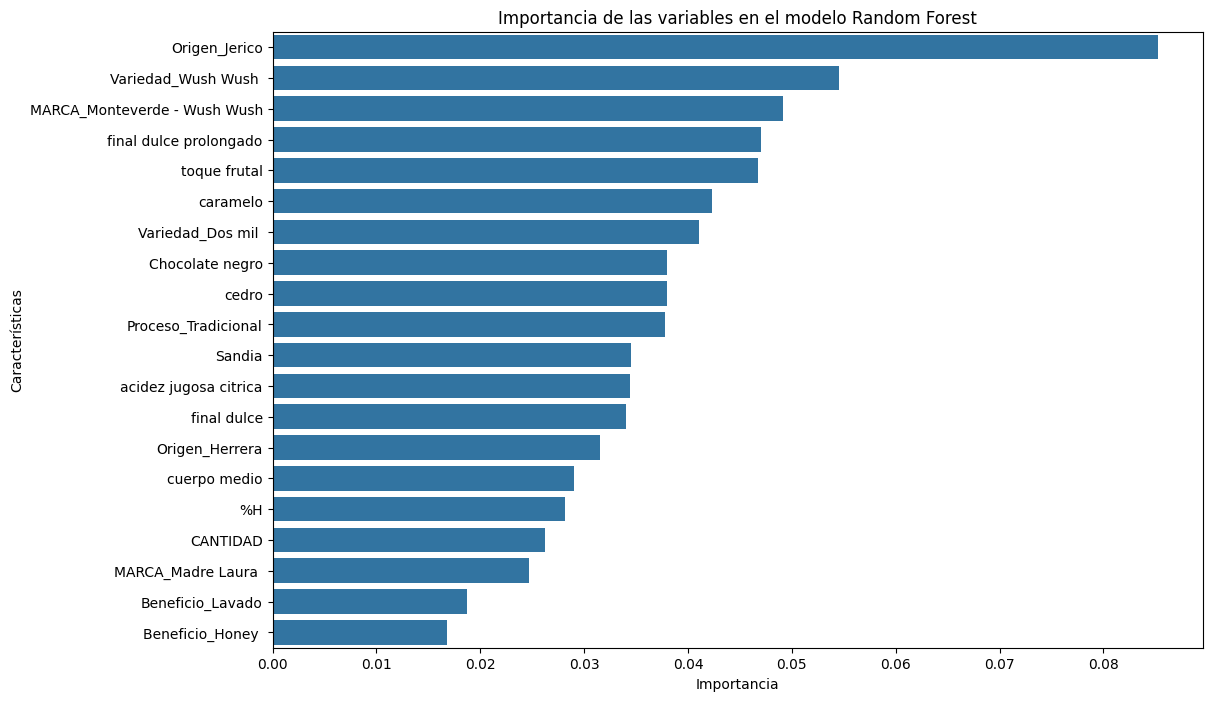

In [55]:
# Primero usamos Feature Importances para ver qué variables son más importantes en el modelo
importances = model1.feature_importances_
# Creamos un DataFrame para visualizar las importancias
importance_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizamos las importancias de las variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Importancia de las variables en el modelo Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()



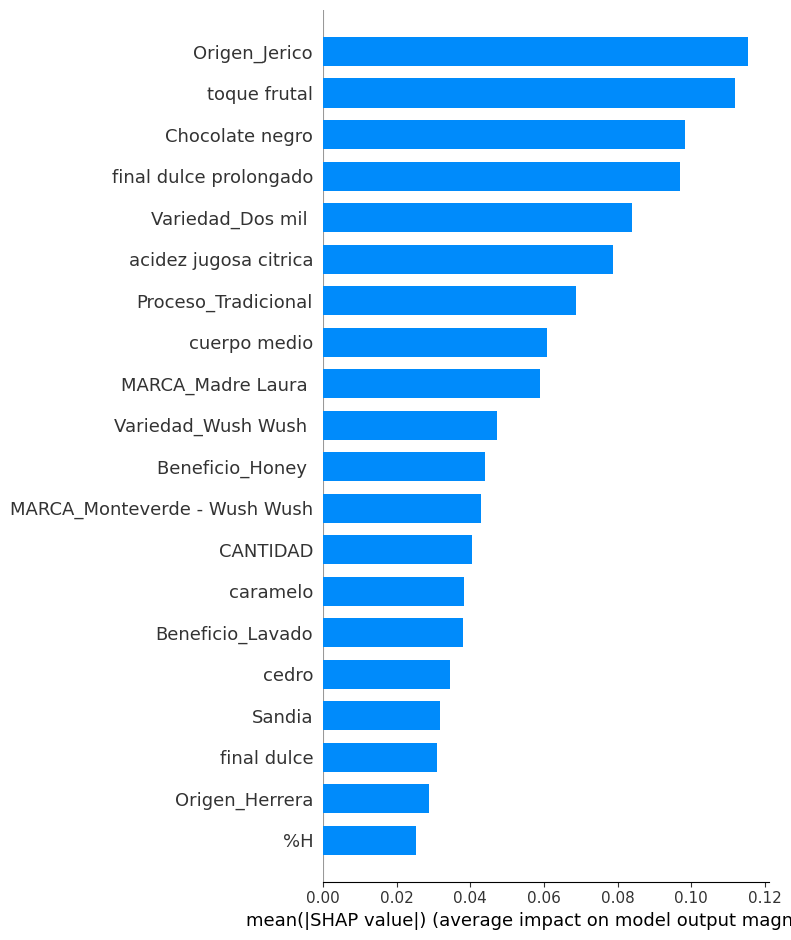

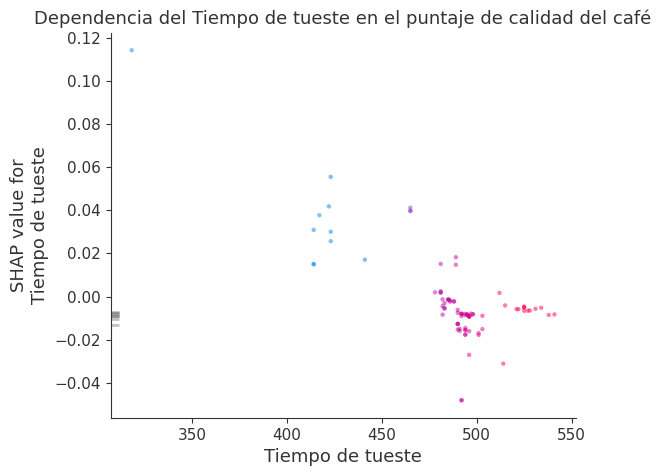

In [56]:
# Ahora usamo SHAP para una interpretación más detallada

explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(df_test)
# Visualizamos los valores SHAP
shap.summary_plot(shap_values, df_test, plot_type="bar", max_display=20)
# Ahora podemos ver cómo cada característica afecta la predicción del modelo
shap.dependence_plot("Tiempo de tueste", shap_values, df_test,
                        interaction_index="Tiempo de tueste",
                        show=True, 
                        alpha=0.5,
                        dot_size=10,
                        title="Dependencia del Tiempo de tueste en el puntaje de calidad del café") 

A continuación, un análisis integrado de ambas técnicas:

1. **Variable más influyente**

   * **Origen\_Jerico** se posiciona como el predictor dominante: los granos procedentes de Jericó reciben, en promedio, un aumento notable en la predicción de calidad.
   * A continuación aparecen **notas sensoriales** (“toque frutal”, “chocolate negro”, “final dulce prolongado”, “caramelo”). Tanto el ranking global del Random Forest como los valores SHAP muestran que la presencia de estos atributos incrementa sustancialmente la puntuación predicha.

2. **Concordancia entre feature-importance y SHAP**

   * El orden general de importancia coincide: tras el origen geográfico y los descriptores organolépticos, cobran relevancia la **variedad** (Dos mil, Wush Wush) y el **proceso** (Tradicional).
   * SHAP añade matices: por ejemplo, indica que un alto grado de “acidez jugosa cítrica” o el perfil “Sandía” aportan impactos positivos en casos particulares, mientras que valores extremos de `%H` o cantidades muy grandes tenderían a “penalizar” ligeramente la calidad.

3. **Factores de menor influencia**

   * Variables puramente cuantitativas como `%H`, `CANTIDAD` o el tipo de beneficio (`Lavado`, `Honey`) ocupan las posiciones más bajas. Su señal predictiva es marginal, sugiriendo que la mera humedad o volumen no explica tanto la calidad como la tipicidad sensorial y de procedencia.

4. **Implicaciones prácticas**

   * **Selección de origen y variedad**: los productores deberían focalizarse en lotes de Jericó y cultivar variedades con atributos organolépticos deseables.
   * **Optimización sensorial**: potenciar notas de “toque frutal” y “chocolate negro” durante la cata y el tueste favorecerá la calificación de taza.
   * **Menor atención a métricas genéricas**: aunque importantes para procesos de manufactura, atributos como humedad o volumen tienen menos peso en la percepción final de calidad.


En resumen, ambos métodos señalan que la **identidad geográfica** y las **características sensoriales concretas** son el núcleo de la predicción de calidad de café; las medidas puramente técnicas o cuantitativas, aunque útiles para el control de proceso, contribuyen mucho menos al score de cata.


### **XGBRegressor**

In [57]:
model2 = XGBRegressor(
    n_estimators=200,         # Más árboles suele mejorar la estabilidad
    max_depth=10,             # Limita la profundidad para evitar sobreajuste
    min_child_weight=1,       # Mínimo de muestras para dividir un nodo
    learning_rate=0.1,        # Tasa de aprendizaje
    subsample=0.8,            # Porcentaje de muestras usadas en cada árbol
    colsample_bytree=0.8,     # Porcentaje de variables usadas en cada árbol
    random_state=42,
    n_jobs=-1                 # Usa todos los núcleos disponibles
)

model2.fit(df_train, y_train)
# Evaluamos el modelo en el conjunto de prueba
y_pred2 = model2.predict(df_test)
# Calculamos el error cuadrático medio (MSE) y el coeficiente de determinación (R^2)
mse2 = mean_squared_error(y_test, y_pred2)
r2_2 = r2_score(y_test, y_pred2)
print(f"Error cuadrático medio (MSE): {mse2}")
print(f"Coeficiente de determinación (R^2): {r2_2}")

Error cuadrático medio (MSE): 0.0025278693413462667
Coeficiente de determinación (R^2): 0.9982502184796893


In [58]:
# Ahora hacemos una validación cruzada para evaluar la estabilidad del modelo

cv_scores2 = cross_val_score(model2, X_full, Y, cv=5, scoring='neg_mean_squared_error')
cv_mse2 = -cv_scores2.mean()
print(f"Error cuadrático medio (MSE) en validación cruzada: {cv_mse2}")

Error cuadrático medio (MSE) en validación cruzada: 0.1415356408175163


### Análisis y conclusiones sobre el desempeño del modelo

Los resultados obtenidos para el modelo muestran lo siguiente:

- **Error cuadrático medio (MSE) en el conjunto de prueba:** 0.0025  
- **Coeficiente de determinación (R²) en el conjunto de prueba:** 0.9982  
- **Error cuadrático medio (MSE) en validación cruzada:** 0.1415  

#### Interpretación

1. **Precisión en el conjunto de prueba:**  
   El MSE extremadamente bajo (0.0025) indica que el modelo es capaz de predecir los puntajes de calidad del café con un error mínimo en los datos de prueba. Además, el R² de 0.9982 sugiere que el modelo explica casi toda la variabilidad de la variable objetivo, lo que es un resultado excelente y evidencia un ajuste muy preciso.

2. **Capacidad de generalización:**  
   El MSE en validación cruzada (0.1415) es más alto que el obtenido en el conjunto de prueba, pero sigue siendo bajo en términos absolutos. Esto significa que, aunque el modelo puede perder algo de precisión cuando se enfrenta a nuevos subconjuntos de datos, su desempeño general sigue siendo muy bueno y consistente.

3. **Diferencia entre prueba y validación cruzada:**  
   La diferencia entre el MSE del conjunto de prueba y el de validación cruzada puede indicar un leve sobreajuste, es decir, el modelo se ajusta muy bien a los datos de entrenamiento y prueba, pero su rendimiento disminuye ligeramente cuando se evalúa en particiones diferentes. Sin embargo, la magnitud de la diferencia no es alarmante y el modelo sigue mostrando una excelente capacidad predictiva.

#### Conclusiones

- El modelo es altamente preciso para predecir la calidad del café, tanto en los datos de prueba como en los distintos subconjuntos evaluados mediante validación cruzada.
- La pequeña brecha entre el MSE de prueba y el de validación cruzada sugiere que el modelo generaliza bien, aunque podría beneficiarse de un ajuste fino de hiperparámetros o de la incorporación de más datos para reducir aún más el riesgo de sobreajuste.
- En general, estos resultados permiten confiar en la robustez del modelo para aplicaciones prácticas, aunque siempre es recomendable validar su desempeño con nuevos datos reales antes de su implementación

### Interpretación y explicabilidad

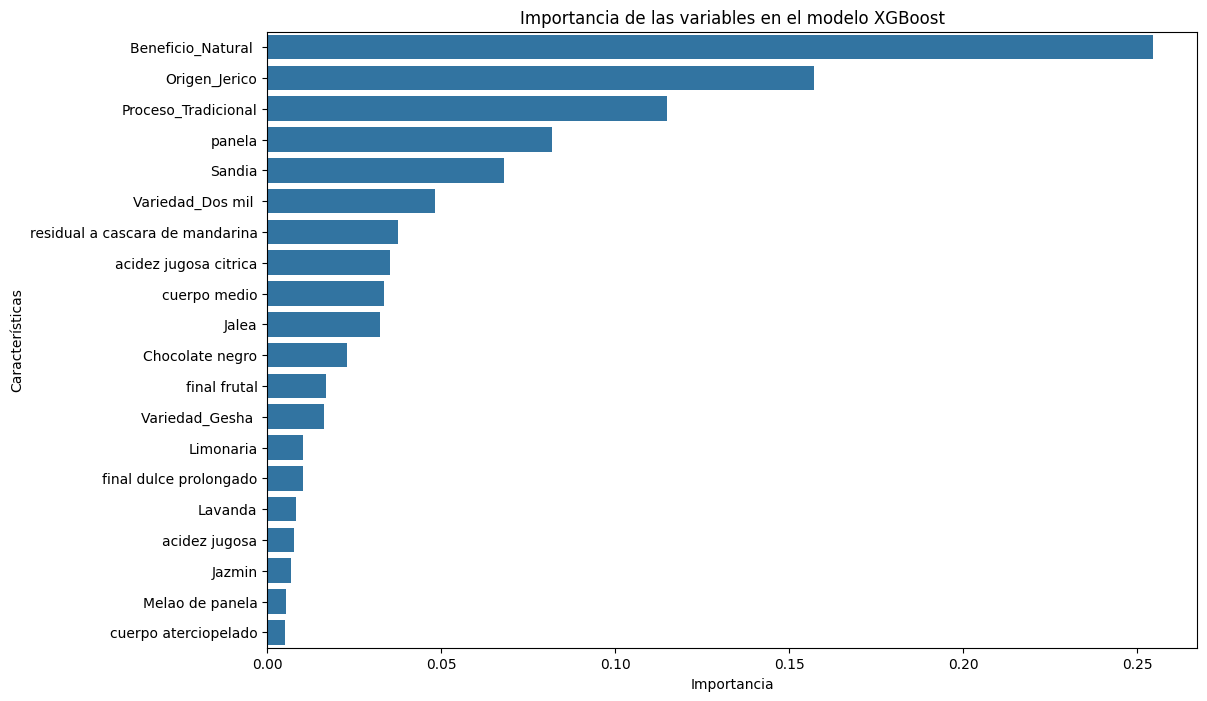

In [59]:
# Con lo anterior hacemos una visualización de la importancia de las variables en el modelo XGBoost
importances2 = model2.feature_importances_
# Creamos un DataFrame para visualizar las importancias
importance_df2 = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': importances2
}).sort_values(by='Importance', ascending=False)
# Visualizamos las importancias de las variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df2.head(20))
plt.title('Importancia de las variables en el modelo XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

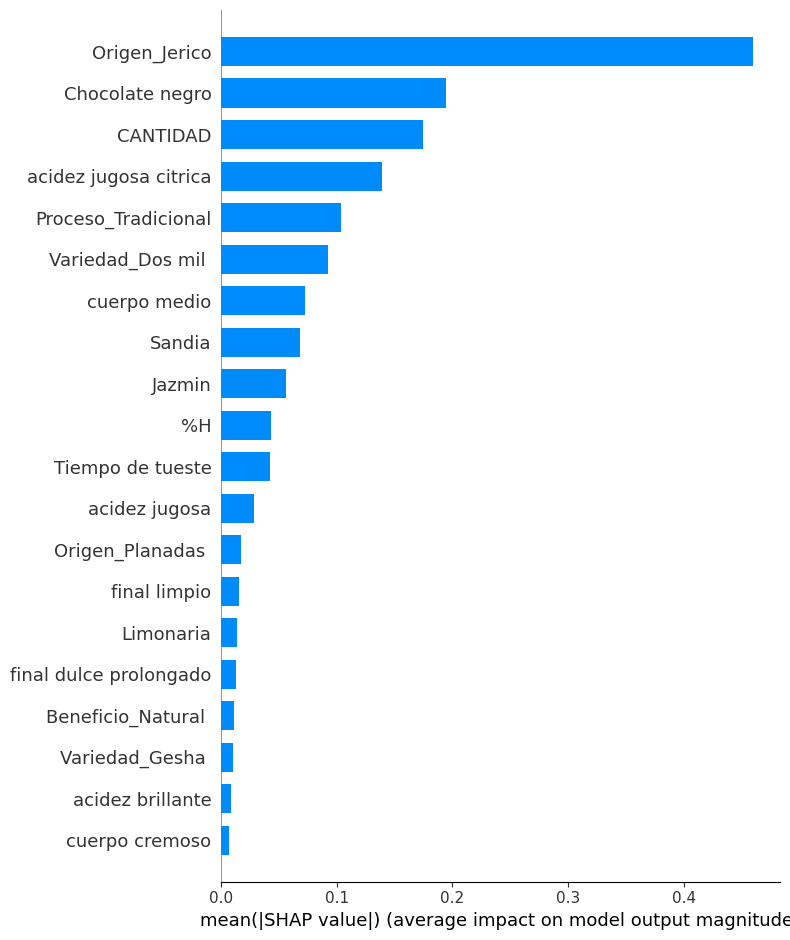

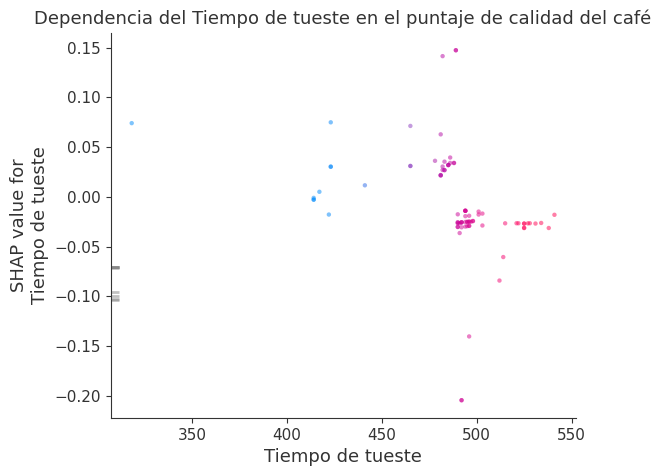

In [60]:
# Ahora realizamos un análisis de SHAP para el modelo XGBoost
explainer2 = shap.Explainer(model2)
shap_values2 = explainer2.shap_values(df_test)
# Visualizamos los valores SHAP
shap.summary_plot(shap_values2, df_test, plot_type="bar", max_display=20)
# Ahora podemos ver cómo cada característica afecta la predicción del modelo
shap.dependence_plot("Tiempo de tueste", shap_values2, df_test,
                        interaction_index="Tiempo de tueste",
                        show=True, 
                        alpha=0.5,
                        dot_size=10,
                        title="Dependencia del Tiempo de tueste en el puntaje de calidad del café")


En el modelo **XGBRegressor**, la variable más influyente es **Beneficio_Natural** (≈0.25), seguida por **Origen_Jerico** (≈0.15) y **Proceso_Tradicional** (≈0.11). Después, destacan varias notas sensoriales como **“panela”** (≈0.08), **“sandía”** (≈0.07) y **“acidez jugosa cítrica”** (≈0.045). El análisis con SHAP confirma este ranking: los lotes con beneficio natural y los provenientes de Jericó tienden a recibir las mayores contribuciones positivas en el puntaje predicho, mientras que el proceso tradicional y ciertos matices de sabor (como panela y sandía) aportan valor en casos específicos.

Al comparar estos resultados con el modelo Random Forest, se observan varias coincidencias: tanto **Origen_Jerico** como **Proceso_Tradicional** y algunas notas frutales y de cacao (“toque frutal”, “chocolate negro”, “acidez cítrica”) son altamente relevantes en ambos modelos. Sin embargo, XGBoost otorga aún más importancia al tipo de beneficio, lo que sugiere que este algoritmo capta mejor las interacciones entre el método de beneficio y otras características (por ejemplo, cómo un proceso natural potencia ciertas notas sensoriales).

En resumen, ambos modelos coinciden en que la **procedencia** y el **perfil organoléptico** son fundamentales para predecir la calidad del café. Sin embargo, XGBoost resalta que el **método de beneficio** (Natural vs. Lavado/Honey) puede ser el factor decisivo para maximizar la puntuación de taza. Esto indica que, además de la geografía y el sabor, la forma en que se procesa el café después de la cosecha tiene un impacto clave en la calidad